In [2]:
import numpy as np

import random
from tqdm import tqdm

import matplotlib.pyplot as plt


import json
import pickle
import os


from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [3]:
tf.__version__

'2.3.1'

In [4]:
def load_file(file_path: str):
    """ A helper functions that loads the file into a list

    :param file_path: path to the data file
    :return parse data into a list
    """
    data = open(file_path, "r").readlines()
    return [line.rstrip() for line in data]

In [5]:
def parse_equations(equations):
    """ A helper functions that parse equations list into a list of tuples.
        each tuple contains lhs and rhs of the equation

    :param ARRAY of equations
    :return factors: (LHS) inputs to the model
            expansions: (RHS) group truth
    """
    factors, expansions = zip(*[line.strip().split("=") for line in equations])
    return factors, expansions

Load the train set and parse each line. For each line, separate LHS and RHS of the equation

In [6]:
equations = load_file('train.txt')
np.random.shuffle(equations)
lhses, rhses = parse_equations(equations)

Using keras Tokenizer, covert the equations to token at character level

In [7]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(equations + ['abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789+-*)('])

eg: equation "4*a**2+67*a-399" is converted to token [9, 1, 21, 1, 1, 3, 7, 11, 14, 1, 21, 2, 10, 19, 19]

In [8]:
tokenizer.texts_to_sequences(['4*a**2+67*a-399'])

[[9, 1, 21, 1, 1, 3, 7, 11, 14, 1, 21, 2, 10, 19, 19]]

In [9]:
tokenizer.sequences_to_texts([[9, 1, 21, 1, 1, 3, 7, 11, 14, 1, 21, 2, 10, 19, 19]])

['4 * a * * 2 + 6 7 * a - 3 9 9']

In [10]:
dataset_size = tokenizer.document_count

In [11]:
"total number of equations in the dataset {}".format(dataset_size)

'total number of equations in the dataset 1000001'

Save the tokenizer to file to use later during inferencing

In [12]:
with open('saved_model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

 character to token map

In [13]:
tokenizer.word_index

{'*': 1,
 '-': 2,
 '2': 3,
 '(': 4,
 ')': 5,
 '1': 6,
 '+': 7,
 '=': 8,
 '4': 9,
 '3': 10,
 '6': 11,
 '5': 12,
 '8': 13,
 '7': 14,
 '0': 15,
 's': 16,
 'n': 17,
 'i': 18,
 '9': 19,
 't': 20,
 'a': 21,
 'c': 22,
 'o': 23,
 'y': 24,
 'z': 25,
 'k': 26,
 'h': 27,
 'j': 28,
 'x': 29,
 'b': 30,
 'd': 31,
 'e': 32,
 'f': 33,
 'g': 34,
 'l': 35,
 'm': 36,
 'p': 37,
 'q': 38,
 'r': 39,
 'u': 40,
 'v': 41,
 'w': 42}

In [132]:
type(model)

__main__.EquationSolver

Let's divide the dataset into train (95%), validation (2.5%) and test (2.5%) 

In [14]:
train_size = int(dataset_size * 0.95)

In [15]:
valid_size = int(dataset_size *0.025)

In [16]:
test_size = int(dataset_size *0.025)

In [69]:
print('train size - {} \nvalidation size - {} \ntest size - {}'.format(train_size, valid_size, test_size))

train size - 950000 
validation size - 25000 
test size - 25000


In [70]:
train_size + valid_size + test_size

1000000

Prepare dataset by considering "lhs" as source sequence and "rhs" as target sequence. A similar strategy is followed for all the three sets i.e. train, test and valid

In [19]:
train_lhs, train_rhs = lhses[0:train_size], rhses[0:train_size]
valid_lhs, valid_rhs = lhses[train_size:train_size + valid_size], rhses[train_size:train_size + valid_size]
test_lhs, test_rhs = lhses[train_size + valid_size:], rhses[train_size + valid_size:]

In [20]:
train_lhs[0]

'n*(n-13)'

In [21]:
train_rhs[0]

'n**2-13*n'

Convert the sequence to list of tokens using Tokenizer

In [22]:
encoded_train_lhs = tokenizer.texts_to_sequences(train_lhs)
encoded_valid_lhs = tokenizer.texts_to_sequences(valid_lhs)
encoded_test_lhs = tokenizer.texts_to_sequences(test_lhs)

In [23]:
encoded_train_rhs = tokenizer.texts_to_sequences(train_rhs)
encoded_valid_rhs = tokenizer.texts_to_sequences(valid_rhs)
encoded_test_rhs = tokenizer.texts_to_sequences(test_rhs)

In [24]:
encoded_test_lhs[0]

[2, 9, 1, 16, 1, 4, 6, 13, 2, 12, 1, 16, 5]

In [25]:
encoded_test_rhs[0]

[3, 15, 1, 16, 1, 1, 3, 2, 14, 3, 1, 16]

Let's convert the list of tokens to ragged tensors to make it easy to store and process data with non-uniform shapes


In [26]:
def ragged_tensor(mat):
    return tf.ragged.constant(np.array(mat)).to_tensor()

In [27]:
X_train = ragged_tensor(encoded_train_lhs)
Y_train = ragged_tensor(encoded_train_rhs)

X_valid = ragged_tensor(encoded_valid_lhs)
Y_valid = ragged_tensor(encoded_valid_rhs)

X_test = ragged_tensor(encoded_test_lhs)
Y_test = ragged_tensor(encoded_test_rhs)

In [28]:
X_train

<tf.Tensor: shape=(950000, 29), dtype=int32, numpy=
array([[17,  1,  4, ...,  0,  0,  0],
       [ 4,  3,  6, ...,  0,  0,  0],
       [ 4,  2, 12, ...,  0,  0,  0],
       ...,
       [ 4,  3,  1, ...,  0,  0,  0],
       [ 4, 10,  1, ...,  0,  0,  0],
       [ 4,  3,  6, ...,  0,  0,  0]], dtype=int32)>

In [29]:
X_valid

<tf.Tensor: shape=(25000, 29), dtype=int32, numpy=
array([[12,  1, 25, ...,  0,  0,  0],
       [ 4,  3, 12, ...,  0,  0,  0],
       [ 4,  6, 14, ...,  0,  0,  0],
       ...,
       [11,  1, 22, ...,  0,  0,  0],
       [ 4,  2,  3, ...,  0,  0,  0],
       [ 4,  2, 10, ...,  0,  0,  0]], dtype=int32)>

In [30]:
Y_train

<tf.Tensor: shape=(950000, 28), dtype=int32, numpy=
array([[17,  1,  1, ...,  0,  0,  0],
       [ 3,  1, 20, ...,  0,  0,  0],
       [ 2, 12,  1, ...,  0,  0,  0],
       ...,
       [ 6, 15,  1, ...,  0,  0,  0],
       [ 6,  3,  1, ...,  0,  0,  0],
       [ 2,  6, 13, ...,  0,  0,  0]], dtype=int32)>

In [31]:
print("shape of X train {}".format(X_train.shape))
print("shape of Y train {}".format(Y_train.shape))
print("shape of X valid {}".format(X_valid.shape))
print("shape of Y valid {}".format(Y_valid.shape))
print("shape of X test {}".format(X_test.shape))
print("shape of Y test {}".format(Y_test.shape))

shape of X train (950000, 29)
shape of Y train (950000, 28)
shape of X valid (25000, 29)
shape of Y valid (25000, 28)
shape of X test (25000, 29)
shape of Y test (25000, 28)


In [32]:
vocab_length = max(tokenizer.word_index.values())

In [33]:
vocab_length

42

numbers from 1 to 42 are attached to one of the character, we can use number 43 indicate start of the sequence

In [34]:
sos_id = vocab_length + 1

In [35]:
total_vocab_length = vocab_length + 1

In [36]:
total_vocab_length

43

The plan is to build a seq2seq model by processing the input sequence (LHS) and predicting the output sequence (LHS). Instead of predicting the output sequence from the final hidden state of the encoder, we feed the output sequence shifted by one to the right. 
Using this strategy, at each time step decoder gets two inputs 1) encoder output vector and 2) the previous target charatcer

So model would require two inputs, input sequence (X_train) and new input (Shifted Output Vector). Let's build the output vector

Once we move the output sequence to right, we need to fill the left most empty position with some identifier, and we can use the sos_id (30) for indicating the start of sequence

In [37]:
def shift_sequence(Y, sos_id = sos_id):
    """ A helper functions to right shift a Tensor and fill the left most place with sos_id

    :param Tensor
    :return Tensor with sos_id concatenated to the left
    """
    sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

In [38]:
X_train_decoder = shift_sequence(Y_train)
X_valid_decoder = shift_sequence(Y_valid)

In [39]:
X_train_decoder

<tf.Tensor: shape=(950000, 28), dtype=int32, numpy=
array([[43, 17,  1, ...,  0,  0,  0],
       [43,  3,  1, ...,  0,  0,  0],
       [43,  2, 12, ...,  0,  0,  0],
       ...,
       [43,  6, 15, ...,  0,  0,  0],
       [43,  6,  3, ...,  0,  0,  0],
       [43,  2,  6, ...,  0,  0,  0]], dtype=int32)>

In [71]:
X_valid_decoder

<tf.Tensor: shape=(25000, 28), dtype=int32, numpy=
array([[43,  2, 12, ...,  0,  0,  0],
       [43,  2,  3, ...,  0,  0,  0],
       [43,  6, 11, ...,  0,  0,  0],
       ...,
       [43,  6,  3, ...,  0,  0,  0],
       [43,  2,  6, ...,  0,  0,  0],
       [43,  2, 10, ...,  0,  0,  0]], dtype=int32)>

X_train_decoder is Y_train with a value 43 (sos_id) prepended to each sequence, which increased the shape of the each sequence from 27 to 28


In [72]:
max_output_length = Y_train.shape[1]

In [73]:
max_output_length

28

At each step, the decoder outputs a score for each character in the output vocabulary, and then the softmax layer turns these scores into probabilities

attention mechanisms. As their name suggests, these are neural network components that learn to select the part of the inputs that the rest of the model should focus on at each time step



In [74]:
BATCH_SIZE = 32

In [43]:
class EquationSolver(keras.models.Model):
    def __init__(self, units=128, encoder_embedding_size=32, decoder_embedding_size=32, input_dim=42, sos_id=43, **kwargs):
        super().__init__(**kwargs)

        # embedding for encoder

        self.sos_id = sos_id
        self.input_dim = input_dim
        """
        The first layer is an Embedding layer, which will convert character IDs into embeddings.
        The embedding matrix needs to have one row per char ID and one column per embedding dimension
        Here we are using embedding dimension of 32
        Whereas the inputs of the model will be 2D tensors of shape [batch size, time steps] i.e. [None, 31], 
        the output of the Embedding layer will be a 3D tensor of shape [batch size, time steps, embedding size] ie. [None, 31, 32]
        """
        self.encoder_embedding = keras.layers.Embedding(input_dim= input_dim + 1, output_dim=encoder_embedding_size)

        """
        encoder is LSTM with 128 units
        return_state=True when creating the LSTM layer so that we can get its final hidden state and 
        pass it to the decoder. Note: LSTM cell has two hidden states (short term and long term)
        """
        self.encoder = keras.layers.LSTM(units, return_sequences=True, return_state=True)

        """
        similar to encoder embedding input [batch_size, time steps] o/p [batch_size, time steps, embedding dimension]
        """
        self.decoder_embedding = keras.layers.Embedding(input_dim=input_dim + 2, output_dim=decoder_embedding_size)

        """
        simply wrap the decoder cell in an AttentionWrapper,
        we provide the desired attention mechanism, we are using Luong attention for this task
        """
        decoder_cell = keras.layers.LSTMCell(units)
        self.luong_attention = tfa.seq2seq.LuongAttention(units)
        self.decoder_cell = tfa.seq2seq.AttentionWrapper(cell=decoder_cell, attention_mechanism=self.luong_attention)

        # output is Dense Layer with input_dim + 1 units
        output_layer = keras.layers.Dense(input_dim + 1)
        # decoder while training
        self.decoder_training_sampler = tfa.seq2seq.sampler.TrainingSampler()
        self.decoder = tfa.seq2seq.BasicDecoder(cell=self.decoder_cell, sampler=self.decoder_training_sampler,
                                                output_layer=output_layer,
                                                batch_size= BATCH_SIZE)

        """
        decoder while inference, 
        almost similar to training decoder except we use GreedyEmbeddingSampler and need to provide maximum_iterations.
        GreedyEmbeddingSampler: 
            computes the argmax of the decoder's outputs and the winner is passed through the decoder_embedding
            Then it is feed to decoder at the next time step
        maximum_iterations: for this task it is set to maximum length of the output sequence in the dataset (29)
        """
        self.decoder_inference_sampler = tfa.seq2seq.sampler.GreedyEmbeddingSampler(embedding_fn=self.decoder_embedding)
        self.inference_decoder = tfa.seq2seq.BasicDecoder(cell=self.decoder_cell,
                                                          sampler=self.decoder_inference_sampler,
                                                          output_layer=output_layer, maximum_iterations=input_dim)

    def call(self, inputs, training=None, **kwargs):
        encoder_input, shifted_decoder_inputs = inputs
        encoder_embeddings = self.encoder_embedding(encoder_input)
        # Note: LSTM cell has two hidden states (short term and long term)
        encoder_outputs, encoder_state_h, encoder_state_c = self.encoder(
            encoder_embeddings,
            training=training)

        encoder_state = [encoder_state_h, encoder_state_c]

        self.luong_attention(encoder_outputs,
                             setup_memory=True)

        decoder_embeddings = self.decoder_embedding(shifted_decoder_inputs)

        decoder_initial_state = self.decoder_cell.get_initial_state(
            decoder_embeddings, batch_size = self.input_dim)
        decoder_initial_state = decoder_initial_state.clone(
            cell_state=encoder_state)

        if training:
            decoder_outputs, _, _ = self.decoder(
                decoder_embeddings,
                initial_state=decoder_initial_state,
                training=training
                )
        else:
            start_tokens = tf.zeros_like(encoder_input[:, 0]) + self.sos_id
            decoder_outputs, _, _ = self.inference_decoder(
                decoder_embeddings,
                initial_state=decoder_initial_state,
                start_tokens=start_tokens,
                end_token=0)

        """
        The decoder outputs (scores) are passed through a softmax
        """
        return tf.nn.softmax(decoder_outputs.rnn_output)

In [122]:
model.summary()

Model: "equation_solver"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1376      
_________________________________________________________________
lstm (LSTM)                  multiple                  82432     
_________________________________________________________________
embedding_1 (Embedding)      multiple                  1408      
_________________________________________________________________
LuongAttention (LuongAttenti multiple                  16384     
_________________________________________________________________
attention_wrapper (Attention multiple                  164352    
_________________________________________________________________
basic_decoder (BasicDecoder) multiple                  169899    
_________________________________________________________________
basic_decoder_1 (BasicDecode multiple              


we compile this model using the "sparse_categorical_crossentropy" loss and Nadam optimizer. Changing optimizer from Adam to Nadam gave a performace boost

In [44]:
model = EquationSolver()
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [45]:
history = model.fit([X_train, X_train_decoder], Y_train, epochs=15)

Epoch 1/15
29688/29688 [==============================] - 1146s 39ms/step - loss: 0.2803 - accuracy: 0.8973
Epoch 2/15
29688/29688 [==============================] - 1255s 42ms/step - loss: 0.0823 - accuracy: 0.9679
Epoch 3/15
29688/29688 [==============================] - 1277s 43ms/step - loss: 0.0556 - accuracy: 0.9787
Epoch 4/15
29688/29688 [==============================] - 1288s 43ms/step - loss: 0.0435 - accuracy: 0.9835
Epoch 5/15
29688/29688 [==============================] - 1284s 43ms/step - loss: 0.0359 - accuracy: 0.9863
Epoch 6/15
29688/29688 [==============================] - 1329s 45ms/step - loss: 0.0334 - accuracy: 0.9874
Epoch 7/15
29688/29688 [==============================] - 1360s 46ms/step - loss: 0.0284 - accuracy: 0.9892
Epoch 8/15
29688/29688 [==============================] - 1300s 44ms/step - loss: 0.0259 - accuracy: 0.9903
Epoch 9/15
29688/29688 [==============================] - 1299s 44ms/step - loss: 0.0237 - accuracy: 0.9911
Epoch 10/15
29688/29688 [===

In [ ]:
# save_weights to tuned weights to use later during inferencing

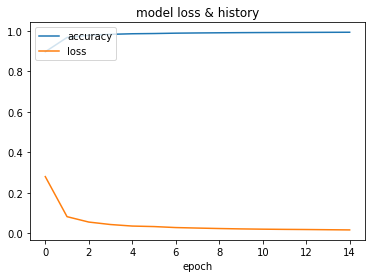

In [127]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model loss & history')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [46]:
model.save_weights(
    'saved_model/equ_model_2', overwrite=True, save_format=None, options=None)

In [ ]:
# model.load_weights('saved_model/equ_model_2')

In [47]:
max_input_length = X_train.shape[1]

In [98]:
def prepare_new_sequences(factors, max_input_length = 29, max_output_length = 28):
    seqs = tokenizer.texts_to_sequences(factors)
    X_new = ragged_tensor(seqs)

    if X_new.shape[1] < max_input_length:
        X_new = tf.pad(X_new, [[0, 0], [0, max_input_length - X_new.shape[1]]])
    X_decoder = tf.zeros(shape=(len(X_new), max_output_length), dtype=tf.int32)
    return X_new, X_decoder

In [99]:
def predict_seqs(factors):
    X_new, X_decoder = prepare_new_sequences(factors)
    Y_probas = model.predict([X_new, X_decoder])

    Y_pred = tf.argmax(Y_probas, axis=-1)
    return Y_pred

In [100]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

In [94]:
test_set = [test_lhs, test_rhs]

In [68]:
with open('test.txt', 'w') as f:
    for l, r in zip(test_lhs, test_rhs):
        f.write("%s=%s\n" % (l, r))

In [116]:
results = []
for e in chunks(test_set[0], 32):
    ids = predict_seqs(e)
    results.append(tokenizer.sequences_to_texts(ids.numpy().tolist()))

In [117]:
def process_result(r):
    return r.replace(' ', '')

In [118]:
def score(true_expansion: str, pred_expansion: str) -> int:
    """ the scoring function - this is how the model will be evaluated

    :param true_expansion: group truth string
    :param pred_expansion: predicted string
    :return:
    """
    return int(true_expansion == pred_expansion)

In [119]:
import itertools
results = list(itertools.chain(*results))
results = list(map(process_result, results))

In [120]:
expected = test_set[1]
count = len(expected)
correct_count = 0

for a, b in zip(results, expected):
    correct_count += score(a, b)

In [121]:
"total score on test set {}".format(correct_count/count)

'total score on test set 0.8388'

references:

https://www.tensorflow.org/addons/api_docs/python/tfa/seq2seq/BasicDecoder

https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt

https://www.tensorflow.org/addons/api_docs/python/tfa/seq2seq/LuongAttention